# Exploring Mental Health Discourse on Reddit

This notebook explores public discourse around mental health on Reddit by analyzing posts from the subreddits r/MentalHealth and r/MentalHealthSupport. It covers data collection, preprocessing, topic modeling, sentiment analysis, and classification of posts. The goal is to understand how discussions have evolved over time and to uncover key themes and sentiments within these communities.

### Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random

import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

In [3]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Connecting to Reddit API

*The code was modified based on resources available at https://github.com/rogerfitz/tutorials/blob/master/subreddit_analysis/0_Setup.ipynb and a tutorial accessed via https://www.youtube.com/watch?v=a3zQdlLwEb4.*

In [4]:
# establish connection with reddit API
reddit = praw.Reddit(
    client_id="81TBuwGeFdL5ZfijNpLxNw",
    client_secret="fn2ztcn8ojr3vewO93h46nZ2YY47mw",
    user_agent="Academic_Winner_5303",
)

#### Obtaining Posts from r/mentalhealth

In [5]:
# specify the subreddit
subreddit_mh = 'MentalHealth'

# fetch posts fromsubreddit
subreddit = reddit.subreddit(subreddit_mh)
word_to_check = "mental health"

In [6]:
for submission in reddit.subreddit('mentalhealth').hot(limit=None):
    print(submission.title)

Men's Mental Health Month
Warning regarding DM's and chatgroups offering "help".
can someone tell me that it's going to be okay
I DON'T LIKE PEOPLE. WELL, SOME. A VERY FEW PEOPLE. 
thinking of cutting myself again. please help.
Describe Depression to a Child
I just want to draw.
How can i help a friend that is really struggling ?
How many people in this forum are clinically diagnosed?
I'm Really Messed Up And Don't Know What To Do
Is there any pill that can make me not want company?
Loneliness
Hello, I can't put my thoughts into words
My ex took his life
Are there any benefits to isolation?
Rock bottom has a basement…
I play tennis and I’m really struggling right now. Please help.
Can you experience splitting if you may not have bpd?
I believe living in my house where I’ve hard my darkest days is contributing to my mental health struggles. 
The feelings are hard to access
need help on how to improve my mental health 
Does anyone else experience this? 
How to get over maladaptive daydre

Did anyone watch Inside Out 2?
The Silent Toll of political dynamics on mental health🧠
I don’t know how to show emotion or cry pls help
I have anxiety related to selling myself on Linkedin and web camera
Mid 30s, on the outside it all looks good. 
My father does not know the amount of mental trauma he keeps giving me. 
I need help 
Struggling to find, sense and feel happy.
My life is going to shit 
Stress and a wish
Too many diagnosis’s?? 
Why am I never someone’s #1
I just need some advice
Mama’s Boy
Blank Bleak Broken Dark Cold Down Frozen 
 Struggling with Relationship Expectations in Recovery? This Might Help!  
I’m afraid I’ll burn out from getting better 
Dealing with being a people pleaser, just to snap under the pressure
I dont deserve anyone
Freaking out, am i the only one on this earth that can deal with me
Help the depression is tearing me up.
guilty guilt
Why am I always cynical and in a bad mood? 
Sometimes I wish I drank alcohol or did drugs
What’s you got to? Worn out, s

Feeling lonely, depressed, and with intrusive thoughts about the past
I have nothing to do and my worries getting to me
My friends might be getting deported. How can I sort of mentally prepare?
What do you think?
I'm hypomanic rn and I have an appointment with the doctor on Monday. 
I don’t know what he will ask next
Need advice 
How do you deal with another person’s mental health issue? 
Social anxiety with crowds
How social media has worsened my depression. 
how do you get over losing a job over your poor mental health 
Am I normal?
Suicide and wanting to die 
Having trouble focusing
GOOD NEWS!! (Finally?)
What is cyber/gangstalking?
This doesn’t make sense to me
I've been riddled with guilt and feeling terrible about myself.
I am paralysed by fear of failure and that is making me anxious, stressed and depressed
I can't do this anymore 
Suicidal thoughts 
How to stop obsessing/fantasising about others?
I’m so depressed I have no motivation to eat
This is just upsetting at this point


Vent about religion through personal experiences with life
How do you ignore all the pain and suffering?
Obsessed with my mother.
Why do I keep having the urge to do something and I can't feel sad for more than like 5 minutes?
Motivated by my self hatred. 
Need guidance
Can you relate?
What is liking someone?
Mutual breakups still suck
How to deal with a manipulative selfish mother who puts on an image of a nice caring mom
Without adderall, it feels like my brain won't turn on and function (prescribed for TRD, fatigue, sleep apnea)
I feel disgusted with myself 
may be going back to depression
Mental health professional told me not to meditate. 
Free Online Dialectical Behavior Therapy
I would appreciate some opinions
I don't know what is wrong with me, any ideas?
Is there more to it?? 
Do You Ever Feel Like Nobody Else Is Real?
Mom is losing her mind. 
Is it normal for your parents to stop caring about your feelings as you get older??
What makes a person dislikeable?
I hate how my frie

Desperate and need advice
It’s so easy to say “just go to therapy”
Why do I hate meeting new people?
Can't stand looking at my mom eating 
How do I stop crying?
I am tired of being angry and afraid all the time
How do I proceed with my mental barriers?
How to learn a language associated with trauma?
what do you do when you’re really mentally unstable and you believe you need help but you can’t seek professional help?
How to get motivated
How do I tell my mom I want therapy?
I Need a Direction
I thought i lost the urges but...
seeing white 
Is getting angry a sign of depression?
Has anyone had transcranial magnetic stimulation? 
Self help resources for victims of organized psychological experimentation
Mental health and wellness community
Should I throw out my cutlery?
I am tired of always being angry or afraid
Shushing myself or saying "shut up" or "you f***ing idiot" out loud. What is this?
Can someone please give me an answer?
Constant Unbearable Pain 
Anger issues or just done with 

In [7]:
subreddit=reddit.subreddit("mentalhealth")
subreddit.over18

False

In [8]:
subreddit.subscribers

468759

In [9]:
subreddit.__dict__

{'display_name': 'mentalhealth',
 '_reddit': <praw.reddit.Reddit at 0x28ed7b760>,
 '_fetched': True,
 '_path': 'r/mentalhealth/',
 'user_flair_background_color': None,
 'submit_text_html': '<!-- SC_OFF --><div class="md"><p>All promotional, survey, research study, or business posts require moderator approval. Please message a moderator to check if your post is suitable. Avoid posting direct links without some context.</p>\n</div><!-- SC_ON -->',
 'restrict_posting': True,
 'user_is_banned': None,
 'free_form_reports': True,
 'wiki_enabled': True,
 'user_is_muted': None,
 'user_can_flair_in_sr': None,
 'header_img': None,
 'title': 'Mental Health',
 'allow_galleries': False,
 'icon_size': None,
 'primary_color': '#005ba1',
 'active_user_count': 289,
 'icon_img': '',
 'display_name_prefixed': 'r/mentalhealth',
 'accounts_active': 289,
 'public_traffic': False,
 'subscribers': 468759,
 'user_flair_richtext': [],
 'name': 't5_2qirg',
 'quarantine': False,
 'hide_ads': False,
 'prediction_l

In [10]:
# define function to fetch posts from subreddit ('MentalHealthSupport')
def fetch_posts(subreddit, category='hot', limit=None):
    if category == 'top':
        posts = subreddit.top(time_filter='year', limit=limit)
    elif category == 'rising':
        posts = subreddit.rising(limit=limit)
    elif category == 'new':
        posts = subreddit.new(limit=limit)
    else:
        posts = subreddit.hot(limit=limit)
    
    rows = []
    for submission in posts:
        row = {
            'title': submission.title,
            'score': submission.score,
            'upvote_ratio': submission.upvote_ratio,
            'created_utc': submission.created_utc,
            'selftext': submission.selftext,
            'subreddit': submission.subreddit,
            'author': str(submission.author),
            'media_only': submission.media_only,
            'permalink': submission.permalink,
            'num_comments': submission.num_comments
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [11]:
mental_health_top = fetch_posts(subreddit, category='top')
mental_health_hot = fetch_posts(subreddit, category='hot')
mental_health_rising = fetch_posts(subreddit, category='rising')
mental_health_new = fetch_posts(subreddit, category='new')

In [12]:
# concatenate dataframes
mental_health_df = pd.concat([mental_health_top,
                               mental_health_hot, 
                               mental_health_rising, 
                               mental_health_new],
                              ignore_index=True)

# drop duplicates
mental_health_df = mental_health_df.drop_duplicates()

In [13]:
mental_health_df['upvotes']=mental_health_df['score']/mental_health_df['upvote_ratio']
mental_health_df['downvotes']=mental_health_df['upvotes']-mental_health_df['score']
mental_health_df['upvotes/subscribers']=mental_health_df['upvotes']/subreddit.subscribers

# convert created_utc to datetimr format 
mental_health_df['created_utc'] = pd.to_datetime(mental_health_df['created_utc'], unit='s')

mental_health_df.sample(5)

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
201,Does anyone ever talk to an imaginary therapist?,149,1.00,2023-08-29 12:16:35,When I'm having trouble sleeping sometimes I ...,mentalhealth,vacuityofnil,False,/r/mentalhealth/comments/164gvkm/does_anyone_e...,62,149.000000,0.000000,0.000318
312,My father tells me daily that he wants to kill...,107,0.99,2023-11-29 11:22:45,Just as the title says its happening on a dail...,mentalhealth,Baby_witch3,False,/r/mentalhealth/comments/186n6ok/my_father_tel...,14,108.080808,1.080808,0.000231
290,All we do is cope,117,0.98,2023-05-02 19:24:21,"Whatever are you doing right now, working, stu...",mentalhealth,IfallInLove2easily,False,/r/mentalhealth/comments/135xlnn/all_we_do_is_...,57,119.387755,2.387755,0.000255
1419,I’m just sad,2,1.00,2024-06-13 05:30:47,"I’m just really sad, like lately I been really...",mentalhealth,Lilnuggie17,False,/r/mentalhealth/comments/1dergg0/im_just_sad/,0,2.000000,0.000000,0.000004
673,Life Is…..,49,0.96,2023-12-31 02:06:47,Life is making mistakes. Life is achieving goa...,mentalhealth,Hackerangel,False,/r/mentalhealth/comments/18uwj3l/life_is/,9,51.041667,2.041667,0.000109


In [14]:
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2029 entries, 0 to 2907
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                2029 non-null   object        
 1   score                2029 non-null   int64         
 2   upvote_ratio         2029 non-null   float64       
 3   created_utc          2029 non-null   datetime64[ns]
 4   selftext             2029 non-null   object        
 5   subreddit            2029 non-null   object        
 6   author               2029 non-null   object        
 7   media_only           2029 non-null   bool          
 8   permalink            2029 non-null   object        
 9   num_comments         2029 non-null   int64         
 10  upvotes              2029 non-null   float64       
 11  downvotes            2029 non-null   float64       
 12  upvotes/subscribers  2029 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64

In [15]:
# create directory to store data 
os.makedirs('data', exist_ok=True)

# create csv 
mental_health_df.to_csv('data/mental_health_posts.csv', index=False)

#### Obtaining Posts  from r/MentalHealthSupport 

In [16]:
# specify the subreddit
subreddit_mhs = 'MentalHealthSupport'

# fetch posts fromsubreddit
subreddit = reddit.subreddit(subreddit_mhs)
word_to_check = "mental health"

In [17]:
for submission in reddit.subreddit('mentalhealthsupport').hot(limit=None):
    print(submission.title)

I don’t think I can do this anymore
I had an appointment for wounded warriors and they never showed up.
Feeling Used and Moving On from a One-Sided Friendship
Decisions to be made
Am I in the wrong? 
Sleeping too much
Where can I get mental health? What are things I can do to make my mental health better?
Struggling with physical health 
Being in a relationship with a narcissist (NPD) while me being diagnosed with BPD.
My fiancé is hiding my medication from me
Scared of getting on medication 
When will the guilt pass?
My parents don’t understand or maybe they don’t want to
My BF touched me while I was asleep and recorded it
i cant do this anymore
My Ex’s mental health is taking a toll on me & I don’t know what to do
Suddenly emotionally numb 
I need help figuring out how to not be disappointed with my life and fomo - I want to do and learn everything that it gets impossible to figure out what I should do. 
Anxiety/panic and being sensitive
I Feel Empty
I thrive off of spitefulness and 

SOS
Office Discrimination?
Missing a friend
Help helping a friend
I’m soo cooked, I need help
Reliable Site to Get Prescription Medication for Severe Depression and Anxiety and Alcoholism?
Bent over by My Insurer
Im absolutely miserable
i feel like my life is a dream and im never fully in control
My Friend's Friend Needs Mental Help
I need someone to talk to (judgment free). I'm trying to get over a limerence or something that may be similar.   
I don’t know what’s wrong with me
Why do I remember so little?
I need help
Lost!
Seeking advice for my friend (25m) going through a manic episode
Psychiatrist wont take me 
Who is to blame?
Roller coaster of emotions and experiences 
Mental health and I don’t know what to do
Why do I suddenly feel so euphoric and happy and then later feel unmotivated and depressed?
Anyone relate?
I can't fucking find a therapist who can help me
Shakes?
I feel like I’m losing the battle 
My mental illness is ruining my life
Fear of nothing
Need advice
Work and m

Sexual Stamina 
Unwillingness to do things after moving to a new city
My sister thinks that Micheal Jackson is going to make her famous
Can anyone please help me out?
Needing guidance on where to find help, UK
I can't take out my body and facial hair which makes me hyper disphoric and I feel so horrible
is the world getting better along with my life?
I am jealous of my friend making more money than me.
I feel guilty, did I do anything wrong?
I suffered a psychosis and wanna tell my story.
Can i or cant?
It’s been 3 years
Do you ever get this feeling?
Admittance?
Unstable life- mental health
My compulsive lying related to OCD is ruining my relationships.
I would like to talk with some one about my long time misdiagnosed chronic pain and my mental state from long term state.
My Friend's Delusions Are Spiraling Out of Control—How Can I Help from Afar?
My brain is my biggest bully. How to fight it?
Losing a supporter/ lover 
I am terrified.
Different person stuck in my body 
Why do I feel 

How do I open up about my SA?
I’m not okay
Hostile Work Environment?
stressed about adhd assessment costs and my parents
please help me people
How do you manage anxiety in your daily life?
It’s back
Seeking help
Skin picking/ lip picking.
Anxiety at 30
Need some advice 
Sleep Issues Evolving into Night Terrors
Rejection trauma and feeling like you don't matter. Venting thoughts on a note pad...maybe some can relate.
I am 42 (AMAB NB) with no job, no home, no support network and no clue how to get out of this rut.
Why does my mind actively contradict everything? 
How do I fix anxiety around people leaving?
Im not feeling well.
They never believe me
Can you get counselling on the nhs as an outpatient?
Help me not get radicalised by Tate rhetoric
Excoriation Disorder
Working
Can I heal in the same environment 
Am I being soft?
How to I tell people I'm ok 
My father died a year ago, and I never shed a tear. Help. 
Still feeling guilty years later
Let my self down. Lost 
What to do when you

In [18]:
subreddit=reddit.subreddit('mentalhealthsupport')
subreddit.over18

False

In [19]:
subreddit.subscribers

46218

In [20]:
subreddit.__dict__

{'display_name': 'MentalHealthSupport',
 '_reddit': <praw.reddit.Reddit at 0x28ed7b760>,
 '_fetched': True,
 '_path': 'r/MentalHealthSupport/',
 'user_flair_background_color': None,
 'submit_text_html': '<!-- SC_OFF --><div class="md"><p>Please provide context to links since they require moderator approval. Promotional posts are not permitted.  Message the moderators if you have any query. Make sure your post follows the rules.</p>\n\n<p>This subreddit is optimized for the new Reddit redesign and official app. Please use the newer design to enjoy the subreddit to its fullest, thank you!</p>\n</div><!-- SC_ON -->',
 'restrict_posting': True,
 'user_is_banned': None,
 'free_form_reports': True,
 'wiki_enabled': True,
 'user_is_muted': None,
 'user_can_flair_in_sr': None,
 'header_img': None,
 'title': 'Mental Health Support & Azal',
 'allow_galleries': False,
 'icon_size': None,
 'primary_color': '#2a4fd5',
 'active_user_count': 5,
 'icon_img': '',
 'display_name_prefixed': 'r/MentalHeal

In [21]:
# define function to fetch posts from subreddit ('MentalHealthSupport')
def fetch_posts(subreddit, category='hot', limit=None):
    if category == 'top':
        posts = subreddit.top(time_filter='year', limit=limit)
    elif category == 'rising':
        posts = subreddit.rising(limit=limit)
    elif category == 'new':
        posts = subreddit.new(limit=limit)
    else:
        posts = subreddit.hot(limit=limit)
    
    rows = []
    for submission in posts:
        row = {
            'title': submission.title,
            'score': submission.score,
            'upvote_ratio': submission.upvote_ratio,
            'created_utc': submission.created_utc,
            'selftext': submission.selftext,
            'subreddit': submission.subreddit,
            'author': str(submission.author),
            'media_only': submission.media_only,
            'permalink': submission.permalink,
            'num_comments': submission.num_comments
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

In [22]:
mental_health_support_top = fetch_posts(subreddit, category='top')
mental_health_support_hot = fetch_posts(subreddit, category='hot')
mental_health_support_rising = fetch_posts(subreddit, category='rising')
mental_health_support_new = fetch_posts(subreddit, category='new')

In [23]:
# concatenate dataframes
mental_health_support_df = pd.concat([mental_health_support_top, 
                                      mental_health_support_hot, 
                                      mental_health_support_rising, 
                                      mental_health_support_new], 
                                     ignore_index=True)

# drop duplicates
mental_health_support_df = mental_health_support_df.drop_duplicates()

In [24]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments
0,I feel hopeless.,157,0.99,1.709293e+09,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154
1,What changes your negative thoughts/ has made ...,45,1.00,1.709444e+09,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21
2,what is the point of living?,43,0.92,1.709354e+09,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24
3,I need a hug,24,0.93,1.709557e+09,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26
4,What are you like after a hug,21,0.97,1.709738e+09,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17


In [25]:
# calculate upvotes and downvotes
mental_health_support_df['upvotes']=mental_health_support_df['score']/mental_health_support_df['upvote_ratio']
mental_health_support_df['downvotes']=mental_health_support_df['upvotes']-mental_health_support_df['score']
mental_health_support_df['upvotes/subscribers']=mental_health_support_df['upvotes']/subreddit.subscribers

# convert 'created_utc' to proper format 
mental_health_support_df['created_utc'] = pd.to_datetime(mental_health_support_df['created_utc'], unit='s')

mental_health_support_df.sample(5)

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
1148,I have a friend who is depressed,1,1.0,2024-06-04 20:46:42,"I have a friend who is depressed, she’s super ...",MentalHealthSupport,Ok-Atmosphere3368,False,/r/MentalHealthSupport/comments/1d87p9u/i_have...,0,1.0,0.0,0.000022
1032,"Not depressed, but nothing in my life brings m...",1,1.0,2024-06-09 04:45:37,I found/saved a dog in September and he is an ...,MentalHealthSupport,DontDrinkMyYoohoo,False,/r/MentalHealthSupport/comments/1dbln45/not_de...,0,1.0,0.0,0.000022
594,I self harm but I’m not suicidal,2,1.0,2024-03-19 07:04:41,Idk if this is normal or not but when I’m very...,MentalHealthSupport,mommamilfies,False,/r/MentalHealthSupport/comments/1bie8ch/i_self...,0,2.0,0.0,0.000043
1278,My Therapist Broke Up With Me,1,1.0,2024-05-31 04:12:11,I’ve been in therapy consistently for the last...,MentalHealthSupport,Charlar247,False,/r/MentalHealthSupport/comments/1d4mxc8/my_the...,0,1.0,0.0,0.000022
1490,How to enjoy things in life?,1,1.0,2024-05-24 02:09:13,"Here's an issue I have.. Basically, when I try...",MentalHealthSupport,whiteingale,False,/r/MentalHealthSupport/comments/1cz9zbj/how_to...,0,1.0,0.0,0.000022


In [26]:
# create directory 
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# create csv 
mental_health_support_df.to_csv('data/mental_health_support_posts.csv', index=False)

In [27]:
mental_health_support_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1923 entries, 0 to 2829
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                1923 non-null   object        
 1   score                1923 non-null   int64         
 2   upvote_ratio         1923 non-null   float64       
 3   created_utc          1923 non-null   datetime64[ns]
 4   selftext             1923 non-null   object        
 5   subreddit            1923 non-null   object        
 6   author               1923 non-null   object        
 7   media_only           1923 non-null   bool          
 8   permalink            1923 non-null   object        
 9   num_comments         1923 non-null   int64         
 10  upvotes              1923 non-null   float64       
 11  downvotes            1923 non-null   float64       
 12  upvotes/subscribers  1923 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64

#### Combine Dataframes (r/MentalHealth and  r/MentalHealthSupport)

In [28]:
# combine both df into one
df = pd.concat([mental_health_support_df, 
                mental_health_df],
               ignore_index=True)

In [29]:
# create csv 
df.to_csv('data/reddit_posts.csv', index=False)

In [30]:
df.info()

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3952 entries, 0 to 3951
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                3952 non-null   object        
 1   score                3952 non-null   int64         
 2   upvote_ratio         3952 non-null   float64       
 3   created_utc          3952 non-null   datetime64[ns]
 4   selftext             3952 non-null   object        
 5   subreddit            3952 non-null   object        
 6   author               3952 non-null   object        
 7   media_only           3952 non-null   bool          
 8   permalink            3952 non-null   object        
 9   num_comments         3952 non-null   int64         
 10  upvotes              3952 non-null   float64       
 11  downvotes            3952 non-null   float64       
 12  upvotes/subscribers  3952 non-null   float64       
dtypes: bool(1), datetime64[ns](1), fl

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
244,M16 I am struggling to make it through tonight.,5,1.0,2024-03-13 03:20:56,I am M16 and I am struggling to make it throug...,MentalHealthSupport,BitFeisty4364,False,/r/MentalHealthSupport/comments/1bdhb09/m16_i_...,1,5.0,0.0,0.000108
3636,I think i want to be dead,1,1.0,2024-06-12 01:36:33,So I really hate my self and how my brain thin...,mentalhealth,Strong_Echidna_8309,False,/r/mentalhealth/comments/1dduyib/i_think_i_wan...,0,1.0,0.0,0.000002
882,Feeling defeated/Unsuccessful,1,1.0,2024-06-14 00:03:18,single 27 year old woman that grew up in pove...,MentalHealthSupport,Brilliant_Race_555,False,/r/MentalHealthSupport/comments/1dfdklv/feelin...,0,1.0,0.0,0.000022
3592,Just started meds,1,1.0,2024-06-12 07:00:55,So I've been diagnosed with borderline persona...,mentalhealth,macaronislut,False,/r/mentalhealth/comments/1de0fu7/just_started_...,1,1.0,0.0,0.000002
2885,need help on how to improve my mental health,2,1.0,2024-06-15 02:38:17,"I’ve been in a relationship for a few months, ...",mentalhealth,Immediate_Matter_169,False,/r/mentalhealth/comments/1dg7y68/need_help_on_...,1,2.0,0.0,0.000004


### Tokenization and Normalization

In [31]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [32]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [33]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

# output statistics for combined df 
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

Numerical Statistics:
              score  upvote_ratio                    created_utc  num_comments  \
count  3952.000000   3952.000000                           3952   3952.000000   
mean     29.656377      0.963462  2024-03-24 12:26:52.582489856     17.146002   
min       0.000000      0.330000            2023-04-06 07:17:59      0.000000   
25%       1.000000      0.970000            2024-03-06 03:13:17      0.000000   
50%       2.000000      1.000000     2024-05-16 05:51:11.500000      1.000000   
75%      31.000000      1.000000  2024-06-11 19:57:04.750000128     13.000000   
max     923.000000      1.000000            2024-06-15 05:32:22    520.000000   
std      70.583208      0.080642                            NaN     40.353728   

           upvotes    downvotes  upvotes/subscribers  
count  3952.000000  3952.000000          3952.000000  
mean     31.134293     1.477916             0.000094  
min       0.000000     0.000000             0.000000  
25%       1.000000     0.00

The descriptive statistics were reviewed separately for each subreddit (r/MentalHealth and r/MentalHealthSupport) rather than in a combined manner. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [34]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

# apply preprocessing to 'selftext' in both df
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    return sentiment_stats, sentiment_category_counts

# function to generate word cloud
def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

# time series plot function
def plot_time_series(subreddit_df, title):
    subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], unit='s')
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

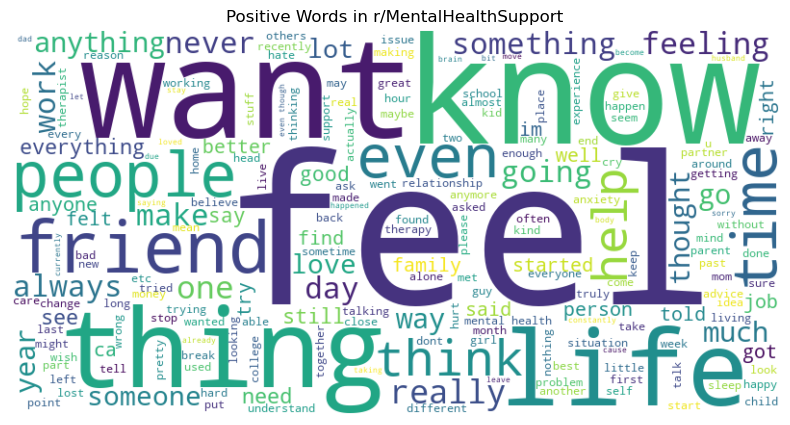

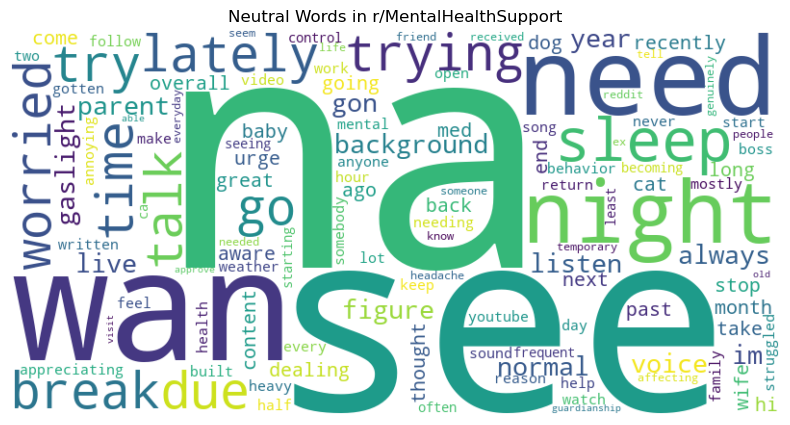

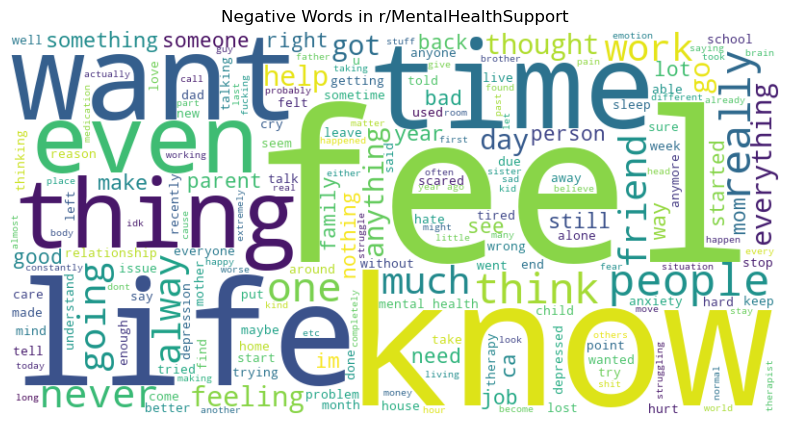

/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_49892/1414374892.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


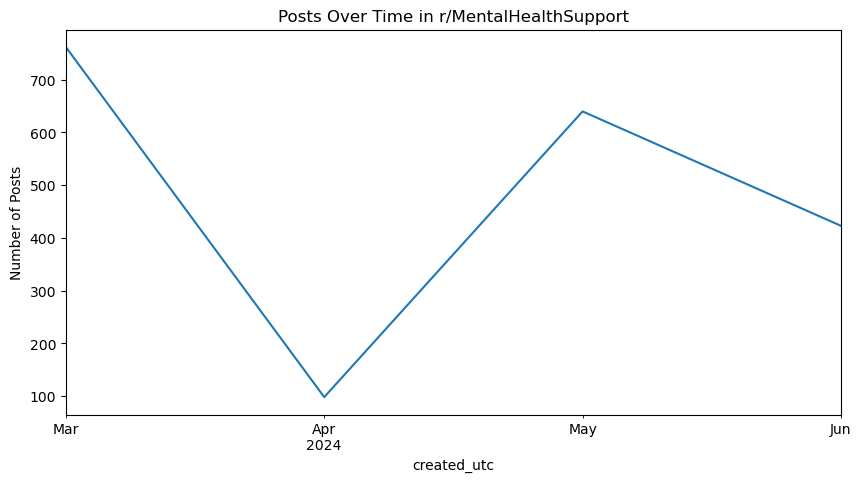


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
              score  upvote_ratio                    created_utc  num_comments  \
count  1923.000000   1923.000000                           1923   1923.000000   
mean      2.806032      0.971310  2024-04-26 14:44:08.229329152      2.140926   
min       0.000000      0.500000            2024-03-01 09:50:37      0.000000   
25%       1.000000      1.000000            2024-03-20 02:46:05      0.000000   
50%       2.000000      1.000000            2024-05-13 21:46:16      0.000000   
75%       3.000000      1.000000            2024-05-30 05:59:18      2.000000   
max     157.000000      1.000000            2024-06-14 16:55:48    154.000000   
std       4.741313      0.076744                            NaN      5.418722   

           upvotes    downvotes  upvotes/subscribers  
count  1923.000000  1923.000000          1923.000000  
mean      2.938743     0.132710             0.000064  
min       0.000000     0.000000

In [35]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

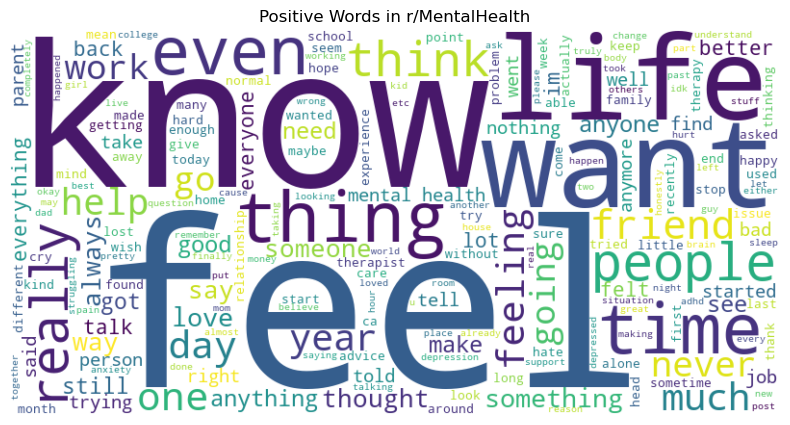

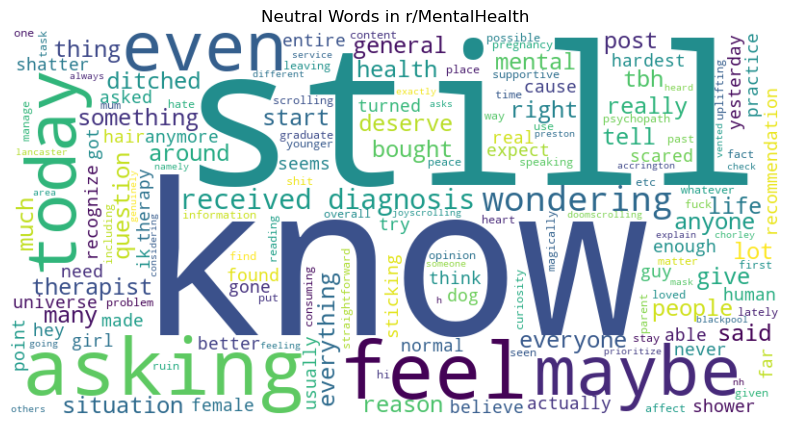

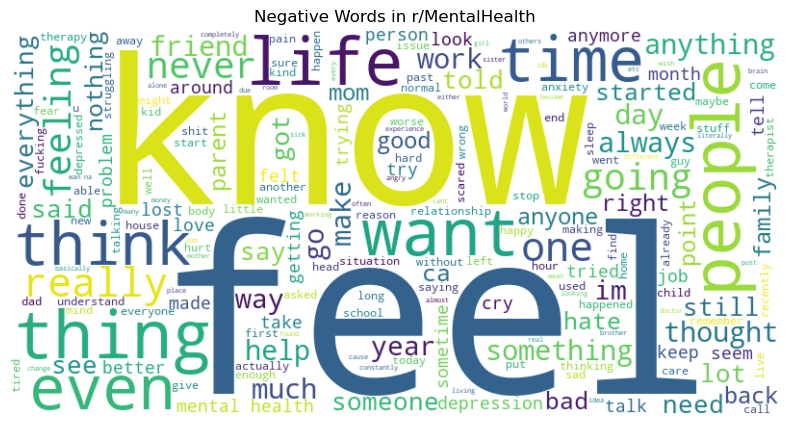

/var/folders/7x/mfyhhlkn0fz774bmn50_szsm0000gn/T/ipykernel_49892/1414374892.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = subreddit_df.resample('M').size()


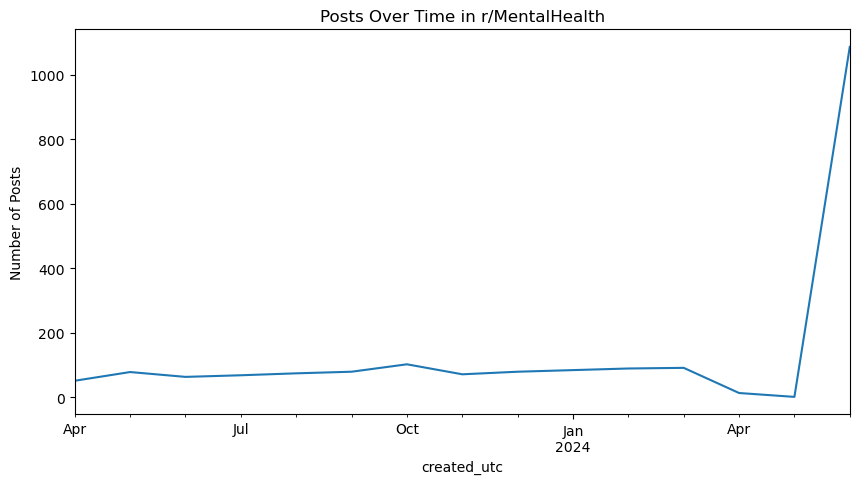


Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio                    created_utc  num_comments  \
count  2029.000000   2029.000000                           2029   2029.000000   
mean     55.103992      0.956023  2024-02-22 03:39:20.956628992     31.367176   
min       0.000000      0.330000            2023-04-06 07:17:59      0.000000   
25%       1.000000      0.950000            2023-10-30 10:04:31      1.000000   
50%      13.000000      0.990000            2024-06-11 05:24:00      8.000000   
75%      70.000000      1.000000            2024-06-13 07:09:34     42.000000   
max     923.000000      1.000000            2024-06-15 05:32:22    520.000000   
std      91.395927      0.083511                            NaN     52.238592   

           upvotes    downvotes  upvotes/subscribers  
count  2029.000000  2029.000000          2029.000000  
mean     57.856837     2.752845             0.000123  
min       0.000000     0.000000       

In [36]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

### Modeling